In [27]:
from src.problems.sudoku import Sudoku
from src.problems.morpian_solitaire import MorpionSolitaire5D

The plan is to test the type of reward distributions that Iterative Sampling, NMCS, NRPA, GNRPA, ... make in the game of morpion solitaire.
After comparing the reward distributions we then attempt to solve some simple morpion solitaire and sudoku games using them as rollouts for
the FlatSolver, MABSolver, and MCTS Solver.

Our goal will then be to test modifications and see if possible improvements can be made. One type of improvement we are keen on making is a 
type of nested search that can support high nesting-level which is computationally intractable at the moment.

In [28]:
morpion_solitaire_5d = MorpionSolitaire5D(20)

In [29]:
# Capturing the reward distribution of a particular set of children involves 
# two components to be determined: (a) the selection policy and (b) the
# rollout algorithm.

# To simplify testing, we write a function which takes both these functions as
# arguments and returns the reward distribution of the children.

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns # type: ignore
from sklearn.neighbors import KernelDensity # type: ignore
from sklearn.neighbors import KernelDensity # type: ignore
from scipy.stats import skew, kurtosis # type: ignore
import numpy as np

def scatter_plot(rewards, children_ids):
    plt.scatter(children_ids, rewards)
    plt.xlabel("Child Index")
    plt.ylabel("Reward")
    plt.title("Rewards per child")
    plt.show()

def plot_kde(important_list, bandwidth=0.75, kernel='gaussian', 
             title='Kernel Density Estimation', xlabel='Reward', ylabel='Density', color='dodgerblue'):
            """
            Plots the kernel density estimation for a given list of integers.
            
            Parameters:
                important_list (list): List of integer values to perform KDE on.
                bandwidth (float): The bandwidth of the kernel. Default is 0.75.
                kernel (str): The kernel to use for KDE. Default is 'gaussian'.
                            Options include 'gaussian', 'tophat', 'epanechnikov', 
                            'exponential', 'linear', 'cosine'.
                title (str): Title of the plot. Default is 'Kernel Density Estimation'.
                xlabel PUCT(str): Label for the x-axis. Default is 'Value'.
                ylabel (str): Label for the y-axis. Default is 'Density'.svg
                color (str): Color of the KDE plot. Default is 'blue'.
            """
            # Convert the list to a numpy array and reshape for scikit-learn
            data = np.array(important_list).reshape(-1, 1)
            
            # Calculate skewness and kurtosis
            data_skewness = skew(important_list)
            data_kurtosis = kurtosis(important_list)

            # Create and fit the KDE model
            kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data)

            # Create a range of values for the x-axis
            x_d = np.linspace(min(important_list) - 1, max(important_list) + 1, 1000).reshape(-1, 1)

            # Evaluate the KDE on the range of values
            log_dens = kde.score_samples(x_d)

            # Plot the results
            plt.fill_between(x_d[:, 0], np.exp(log_dens), color=color, alpha=0.5)
            plt.plot(data[:, 0], -0.01 - 0.1 * np.random.rand(len(data)), 'ro', label='Data points')
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend()
            
            # Annotate skewness and kurtosis
            plt.text(x_d[0, 0], np.max(np.exp(log_dens)) * 0.8, f'Skewness: {data_skewness:.2f}', color='black')
            plt.text(x_d[0, 0], np.max(np.exp(log_dens)) * 0.7, f'Kurtosis: {data_kurtosis:.2f}', color='black')

            plt.axvline(np.mean(important_list), color='r', linestyle='dashed', linewidth=1)

            plt.show()

def get_reward_info(problem, initialize_children_info, selection_policy, rollout_algorithm, budget = 100):

    # Saving the initial state of the problem
    initial_state = problem.save_state()

    rewards = []
    children_corresponding_to_rewards = []

    child_actions = problem.get_valid_moves()
    child_properties = initialize_children_info(child_actions)

    for _ in tqdm(range(budget)):

        selected_child = selection_policy(child_properties)

        # Play the selected move
        problem.apply_action(child_actions[selected_child])

        reward = rollout_algorithm(problem)

        rewards.append(reward)
        children_corresponding_to_rewards.append(selected_child)

        # Reset the problem
        problem.load_state(initial_state)

    # Making plots and stuff

    # First a scatter plot of the rewards vs child index (A Band/Box plot would be better)
    scatter_plot(rewards, children_corresponding_to_rewards)

    # Then making a kernel density plot of the list rewards.
    plot_kde(rewards)

def get_reward_info_all_select(problem, rollout_algorithm, budget = 100):
    # Saving the initial state of the problem
    initial_state = problem.save_state()

    child_actions = problem.get_valid_moves()

    rewards = np.zeros((len(child_actions), budget))

    for i in tqdm(range(budget)):

        for j, action in enumerate(child_actions[0:0]):
             
            # Play the selected move
            problem.apply_action(action)

            reward = rollout_algorithm(problem)
            rewards[j, i] = reward

            # Reset the problem
            problem.load_state(initial_state)

    # Making plots and stuff

    # First a scatter plot of the rewards vs child index (A Band/Box plot would be better)
    list_of_rewards = []
    children_corresponding_to_rewards = []
    for i in range(len(child_actions)):
        for j in range(budget):
            list_of_rewards.append(rewards[i][j])
            children_corresponding_to_rewards.append(i)

    scatter_plot(rewards, children_corresponding_to_rewards)

    # Then making a kernel density plot of the list rewards.
    for i in range(len(child_actions)): 
        plot_kde(rewards[i, :], title = "KDE Plot for child " + str(i))

In [30]:

# Testing this out with a Flat MonteCarlo Selection Policy and Iterative Sampling
import random
import copy

def initialize_children_info(child_actions):
    return [{} for _ in range(len(child_actions))]

def selection_policy(child_properties):
    return random.randint(0, len(child_properties) - 1)

def iterative_sampling(problem):
    # Can actually write a default
    # flat rollout mechanism here.
    problem_copy = copy.deepcopy(problem)

    while not problem_copy.is_game_finished():
        valid_moves = problem_copy.get_valid_moves()
        if len(valid_moves) == 0:
            return problem_copy.get_penalty() + problem_copy.get_score()
        move = random.choice(valid_moves)
        problem_copy.play_action(move)

    return problem_copy.get_score() 

get_reward_info(morpion_solitaire_5d, initialize_children_info, selection_policy, iterative_sampling)

 17%|█▋        | 17/100 [00:06<00:29,  2.78it/s]


KeyboardInterrupt: 

Testing rewards for child  0


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


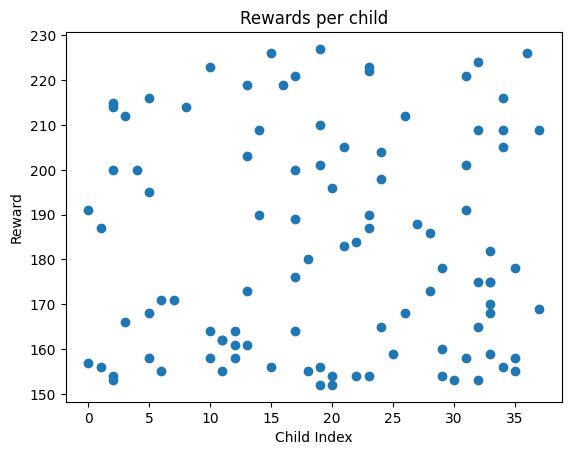

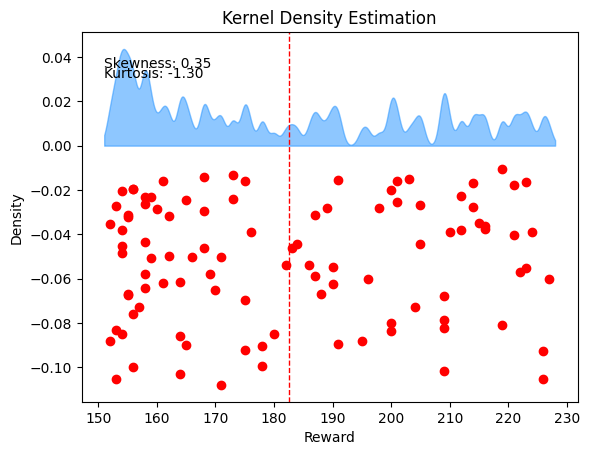

Testing rewards for child  1


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


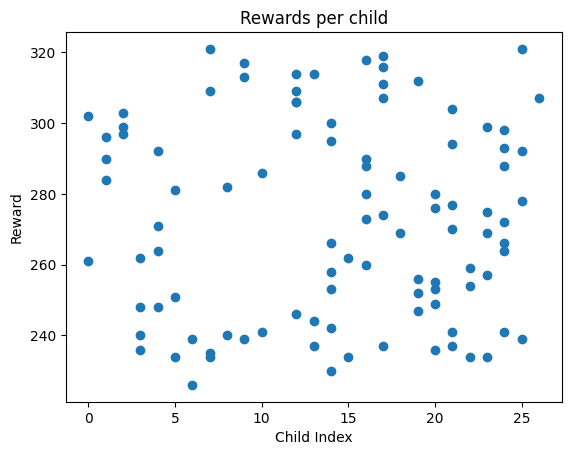

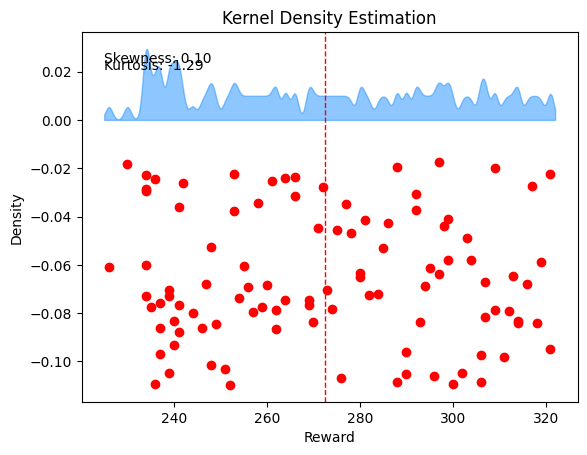

Testing rewards for child  2


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


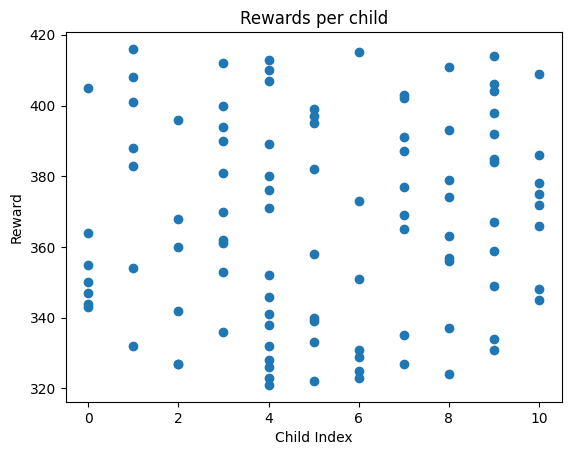

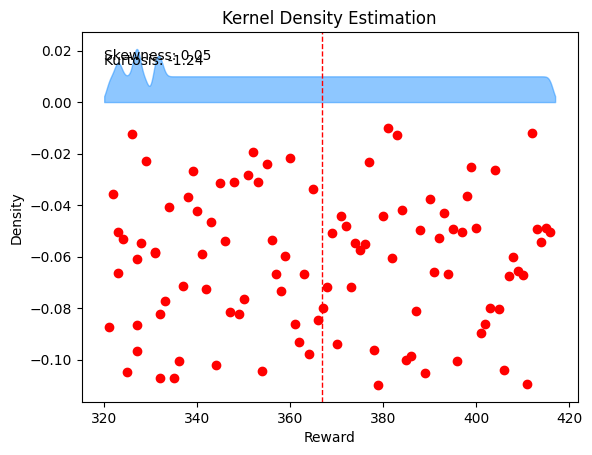

Testing rewards for child  3


100%|██████████| 100/100 [00:04<00:00, 21.16it/s]


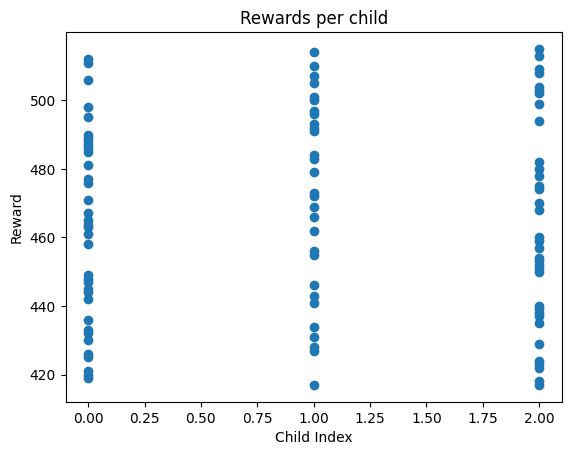

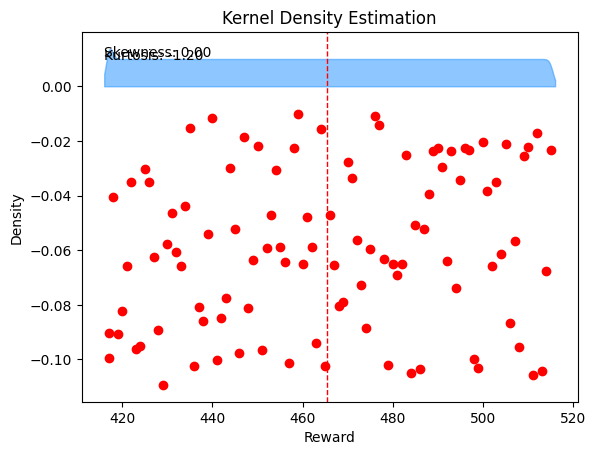

Testing rewards for child  4


  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: empty range in randrange(0, 0)

In [ ]:
# We now repeat the above experiment for each child and make the appropriate plots

child_actions = morpion_solitaire_5d.get_valid_moves()
original_problem_state = morpion_solitaire_5d.save_state()
for i, child_action in enumerate(child_actions):
    print("Testing rewards for child ", i)
    # Apply the child action.
    morpion_solitaire_5d.apply_action(child_action)
    # Testing the rewards at this point.
    get_reward_info(morpion_solitaire_5d, initialize_children_info, selection_policy, iterative_sampling)
    # Restoring the original problem.
    morpion_solitaire_5d.load_state(original_problem_state)


100%|██████████| 100/100 [00:00<00:00, 1684459.44it/s]


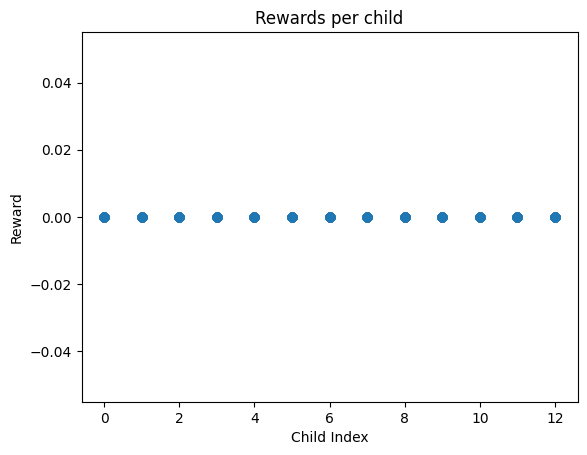

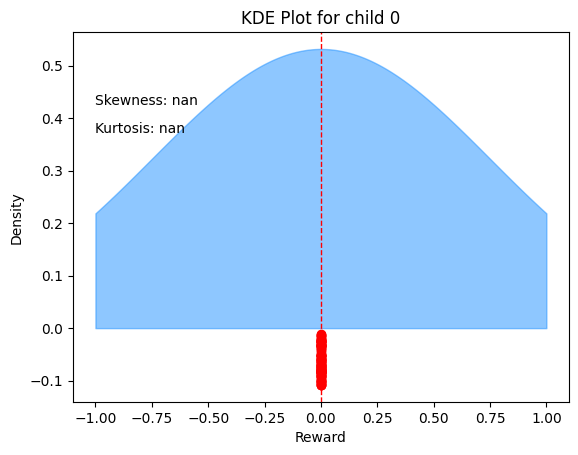

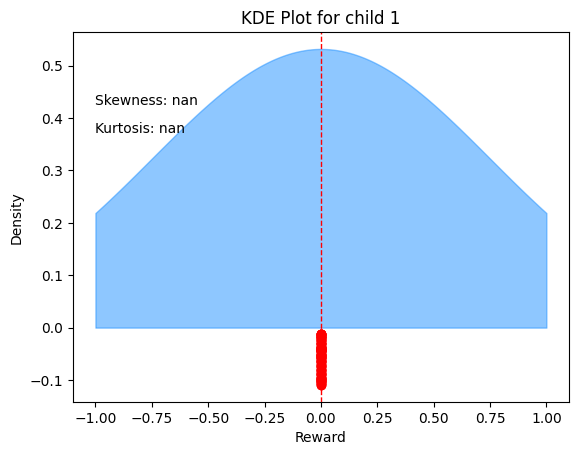

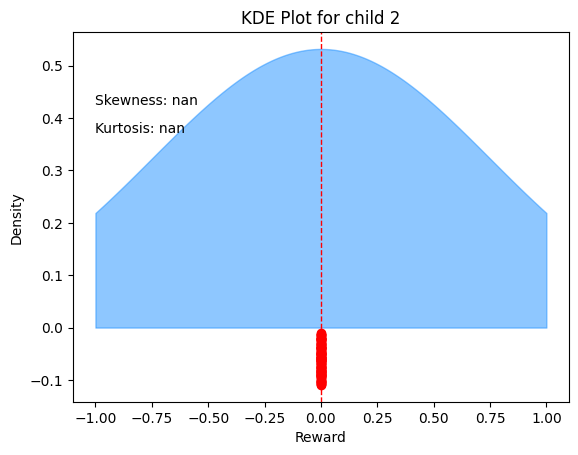

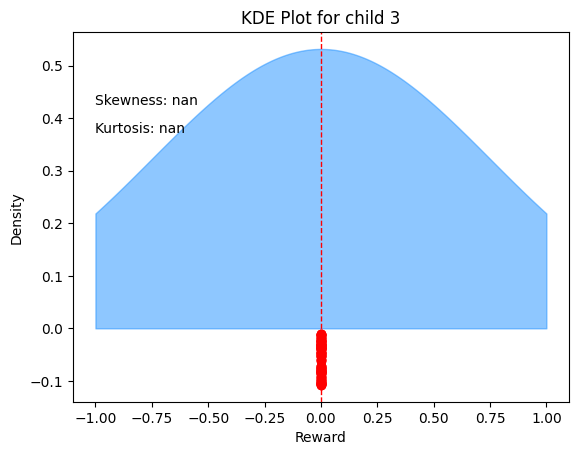

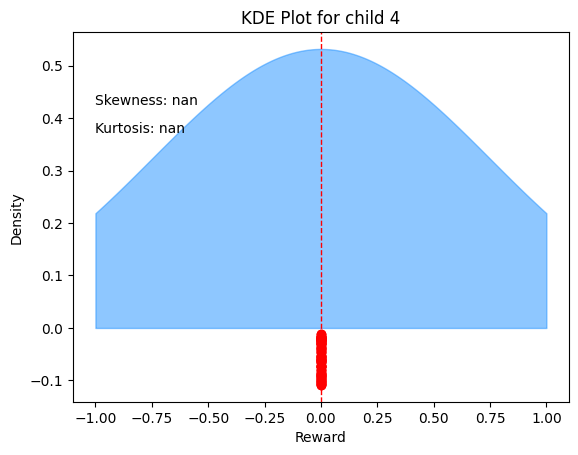

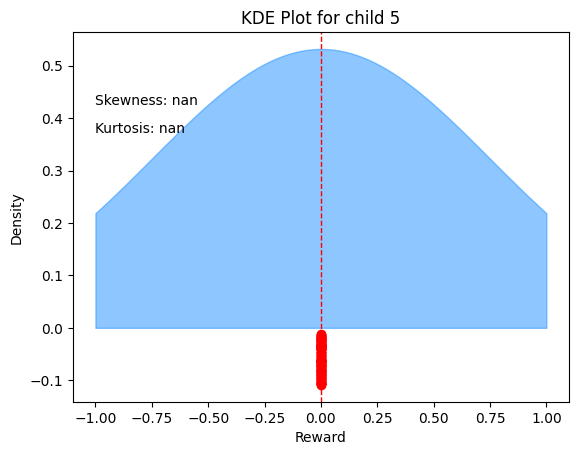

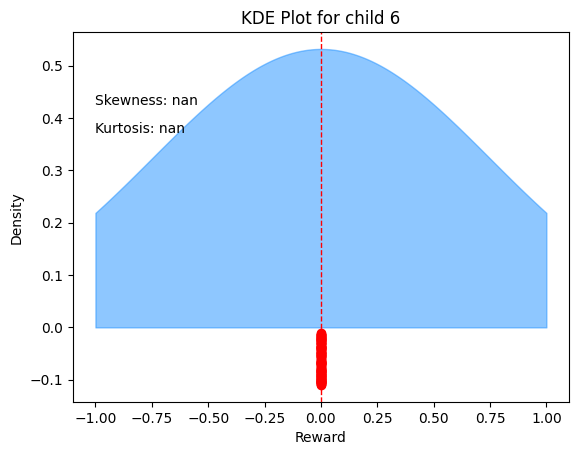

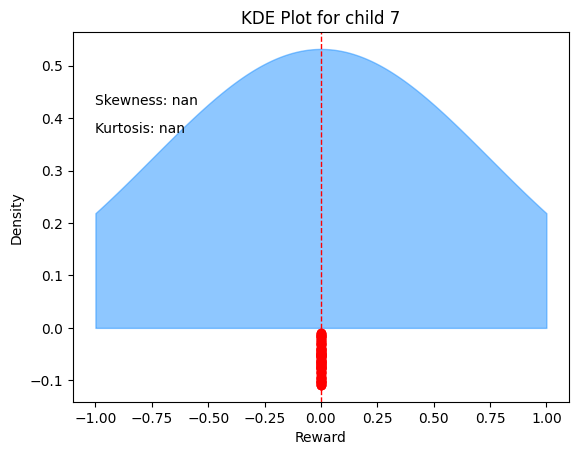

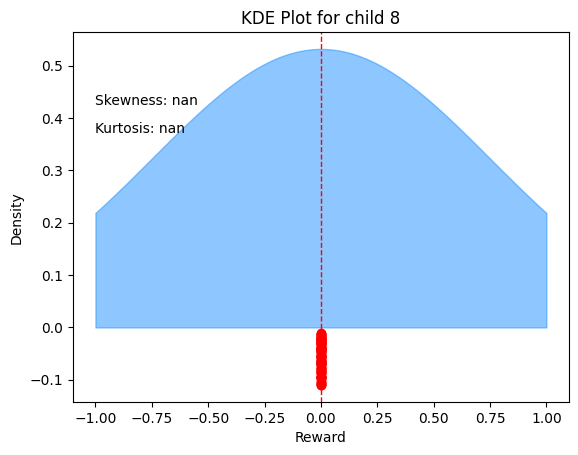

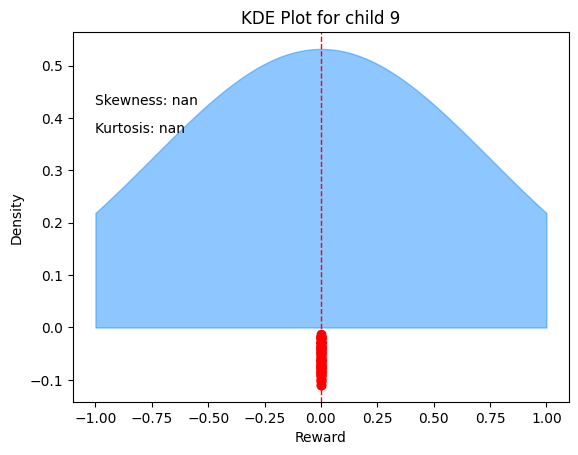

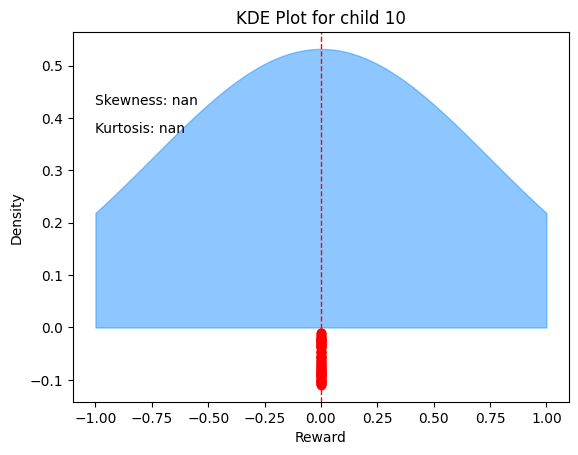

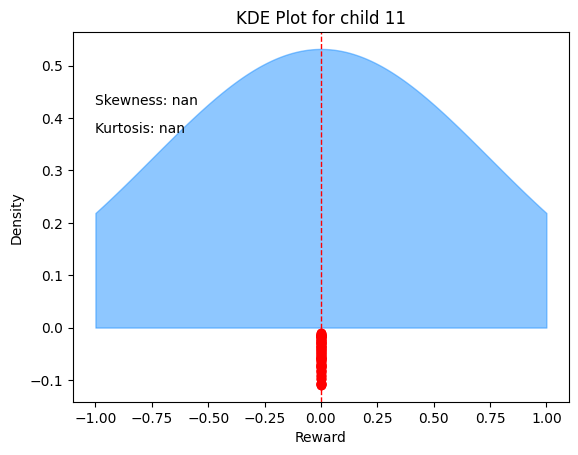

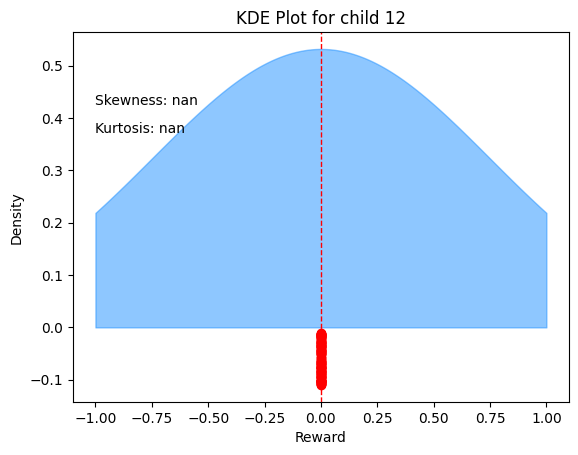

In [31]:
get_reward_info_all_select(morpion_solitaire_5d, iterative_sampling, budget = 100)